In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LambdaCallback
from keras import backend as K
import keras
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import Callback
import matplotlib.pyplot as plt

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# ratio of the dataset you wanan use
ratio = 1
subset_size = int(ratio * len(X_train))
X_train = X_train[:subset_size].reshape((subset_size, -1))/255.0
y_train = to_categorical(y_train[:subset_size], 10)

subset_size = int(ratio * len(X_test))
X_test = X_test[:subset_size].reshape((subset_size, -1))/255.0
y_test = to_categorical(y_test[:subset_size], 10)


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense(128, activation='relu', input_shape=(128,)))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ds_size = 60000  * ratio
batchsize_train = 128
dense_size = 128
n_batches = int(ds_size // batchsize_train)
n_epochs = 6
n_layers = 2

In [ ]:
shapes = (n_batches, batchsize_train, dense_size)
layer_activations = []
for _ in range(n_layers):
  epochs = []
  for i in range(n_epochs):
    epochs.append(np.empty(shapes))
  layer_activations.append(epochs)
model_output = []
weights = []

class CustomCallback(Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()
        for i in range(n_layers):
          model_output.append(model.layers[i].output)
        # self.neuron_activations = []
        self.ok = False #used for testing

    def on_epoch_begin(self, epoch, logs=None):
      self.neuron_activations = []
      for i in range(n_layers):
        self.neuron_activations.append(layer_activations[i][epoch])
      if epoch == 0: ## replace 0 with the epoch you wanna test
        self.ok = True

    def on_batch_begin(self, batch, logs=None):
        get_activations = K.function([model.layers[0].input], model_output)
        if batch != (n_batches):  # we ignore the last, uncompleted batch so we can have a matrix
          get_act = get_activations([X_train[(batch) * batchsize_train: (batch + 1) * batchsize_train]])
          for i in range(n_layers):
            activations = get_act[i]
            self.neuron_activations[i][batch]= np.array(activations)
        if batch == 50 and self.ok == True:
           weights.append(model.get_weights())
           self.ok = False

custom_callback = CustomCallback()

model.fit(X_train, y_train, epochs=n_epochs, batch_size=batchsize_train, callbacks=[custom_callback])


Epoch 1/6
  6/469 [..............................] - ETA: 34s - loss: 2.1214 - accuracy: 0.3398

469/469 [==============================] - 23s 43ms/step - loss: 0.3072 - accuracy: 0.9160
Epoch 2/6
469/469 [==============================] - 8s 18ms/step - loss: 0.1226 - accuracy: 0.9637
Epoch 3/6
469/469 [==============================] - 8s 18ms/step - loss: 0.0842 - accuracy: 0.9749
Epoch 4/6
469/469 [==============================] - 8s 16ms/step - loss: 0.0635 - accuracy: 0.9807
Epoch 5/6
469/469 [==============================] - 9s 18ms/step - loss: 0.0491 - accuracy: 0.9856
Epoch 6/6
469/469 [==============================] - 9s 19ms/step - loss: 0.0396 - accuracy: 0.9879


Check if it works as intended

In [ ]:
# small_w1 = np.array(weights[0][0])
# small_b1 = np.array(weights[0][1])
# small_w2 = np.array(weights[0][2])
# small_b2 = np.array(weights[0][3])
# result = np.matmul(X_train[50*128], small_w1) + small_b1
# # print(result)
# result = np.maximum(0, result)
# result2 = np.matmul(result, small_w2) + small_b2
# print(result)

Properly arrange list

In [ ]:
neuron_activations = []
for j in range(n_layers):
  for i in range(n_epochs):
    layer_activations[j][i] = np.reshape(layer_activations[j][i], (n_batches * batchsize_train, dense_size ))
    layer_activations[j][i] = layer_activations[j][i].T.reshape((dense_size,-1))
  neuron_activations.append(np.hstack(layer_activations[j]))


Plot histogram of the values an arbitrary neuron has

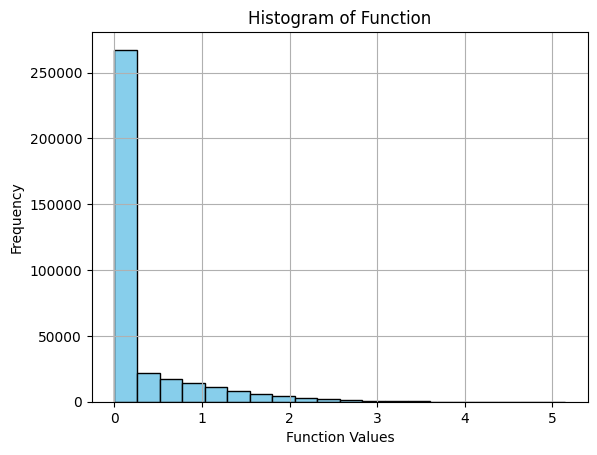

In [ ]:
plt.hist(neuron_activations[0][-5], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Function')
plt.xlabel('Function Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We now compute the ranges of the neurons

In [ ]:
ranges = np.empty((n_layers,dense_size,2))
for layer in range(n_layers):
  for i in range(dense_size):
    ranges[layer][i][0] = np.min(neuron_activations[layer][i])
    ranges[layer][i][1] = np.max(neuron_activations[layer][i])

Get activations from tests

In [ ]:
get_testing_a = K.function([model.layers[0].input],
                                  model_output)
get_label_pred = K.function([model.layers[0].input],
                                  [model.layers[-1].output])
layers_output = get_testing_a([X_test])
label_pred = get_label_pred([X_test])[0]

In [ ]:

max_indices = np.argmax(label_pred, axis=1)
y_test_predict = np.zeros((max_indices.size, 10))
y_test_predict[np.arange(max_indices.size), max_indices] = 1 # one hot encoded

Test if it works

In [ ]:
# w_test = model.get_weights()
# small_w1 = np.array(w_test[0])
# small_b1 = np.array(w_test[1])
# inpt = np.array(X_test[50])
# actvv = np.matmul(inpt,small_w1) + small_b1
# actvv = np.maximum(0, actvv)
# small_w2 = np.array(w_test[2])
# small_b2 = np.array(w_test[3])
# actvv2 = np.matmul(actvv, small_w2) + small_b2
# actvv2 = np.maximum(0, actvv2)

Rearrange the list properly

In [ ]:
layers_output= np.array(layers_output)
layers_output = layers_output.transpose(0, 2, 1)

In [ ]:
n_images = len(layers_output[0][0])
percentages = np.empty(n_images)
for i in range(n_images):
  count = 0
  for layer in range(n_layers):
    for neuron in range(dense_size):
        if ranges[layer][neuron][0] <= layers_output[layer][neuron][i] <= ranges[layer][neuron][1] :
          count +=1
  percentages[i] = count / (n_layers * dense_size) * 100

In [ ]:
indices = np.arange(len(percentages))

In [ ]:
remove_count = int(len(percentages) * 0.025)
sorted_indices = np.argsort(percentages)
top_indices = sorted_indices[-remove_count:]
bottom_indices = sorted_indices[:remove_count]

In [ ]:
trimmed_percentages = np.delete(percentages, np.concatenate((top_indices, bottom_indices)))

In [ ]:
percentage_count = 0
for percentage in percentages:
  if percentage == 100.:
    percentage_count += 1
print(percentage_count)

9973


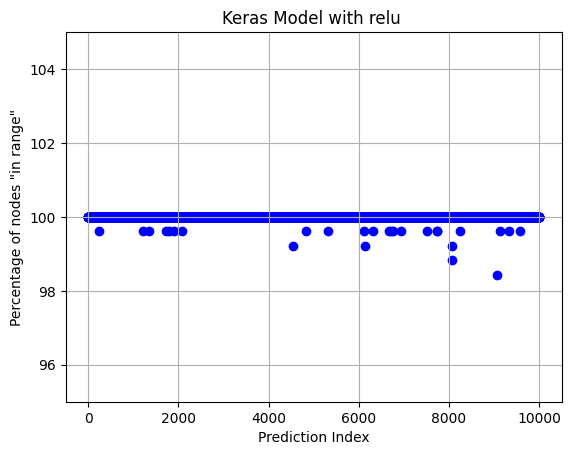

In [ ]:
plt.scatter(np.arange(len(percentages)), percentages, color='blue', marker='o')
plt.title('Keras Model with relu ')
plt.xlabel('Prediction Index')
plt.ylabel('Percentage of nodes "in range"')
plt.grid(True)
plt.ylim(95, 105)
plt.show()

Check which predictions are right

In [ ]:
result = np.equal(y_test, y_test_predict)

result = result.all(axis=1)